In [97]:
import pandas as pd
import numpy as np
import urllib.request as urq
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.linear_model import LogisticRegression

In [98]:
# Baixar e carregar a base de dados
urq.urlretrieve('https://raw.githubusercontent.com/jefferson-oliva/databases/master/wine.mat', 'wine.mat')
mat = scipy.io.loadmat('wine.mat')

In [99]:
bd = pd.DataFrame(np.hstack((mat['X'], mat['y'])))

In [100]:
colunas = ['Alcool', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280-OD315', 'Proline', 'Classe']

In [101]:
bd.columns = colunas

In [102]:
bd.shape

(129, 14)

In [103]:
print(bd.head())


   Alcool  Malic acid   Ash  Alcalinity of ash  Magnesium  Total phenols  \
0   13.29        1.97  2.68               16.8      102.0           3.00   
1   14.30        1.92  2.72               20.0      120.0           2.80   
2   13.68        1.83  2.36               17.2      104.0           2.42   
3   14.06        2.15  2.61               17.6      121.0           2.60   
4   14.22        1.70  2.30               16.3      118.0           3.20   

   Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue  \
0        3.23                  0.31             1.66             6.00  1.07   
1        3.14                  0.33             1.97             6.20  1.07   
2        2.69                  0.42             1.97             3.84  1.23   
3        2.51                  0.31             1.25             5.05  1.06   
4        3.00                  0.26             2.03             6.38  0.94   

   OD280-OD315  Proline  Classe  
0         2.84   1270.0     1.0  


In [104]:
# Verificar valores únicos na coluna 'Classe'
bd['Classe'].unique()


array([1., 0.])

In [105]:
# Ajustar a base de dados
y = bd['Classe'].copy()


(array([119.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

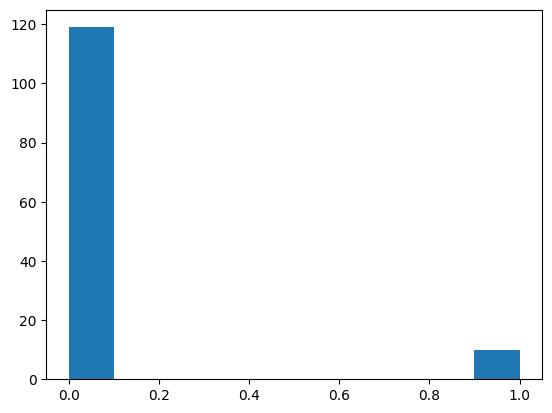

In [106]:
plt.hist(bd['Classe'])

In [107]:
# Ajuste dos dados
y = bd['Classe'].copy()
for i in range(len(y)):
    if (y[i] == 1):
        y[i] = -1
    else:
        y[i] = 1

In [108]:
# Removendo colun Classe
x = bd.drop(labels = ['Classe'], axis = 1)

<ipython-input-109-8036ec4cdf6a>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


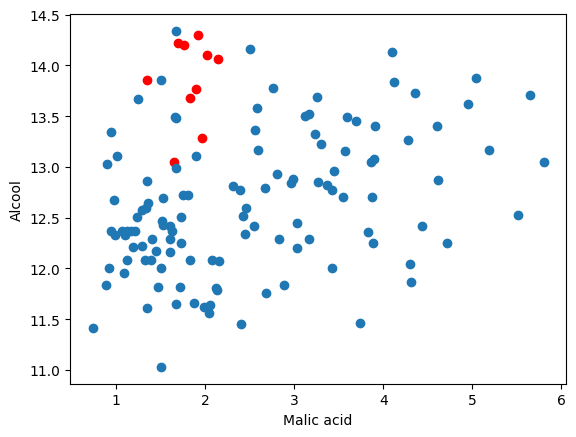

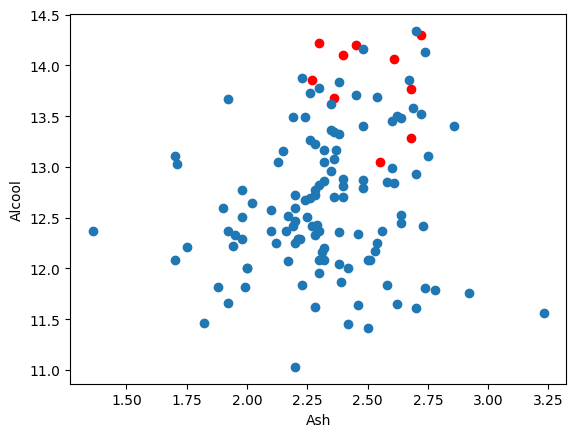

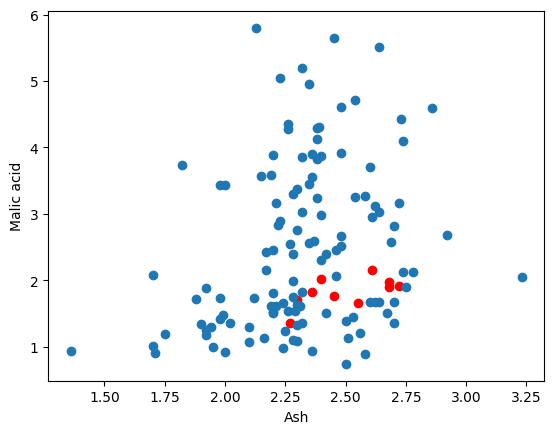

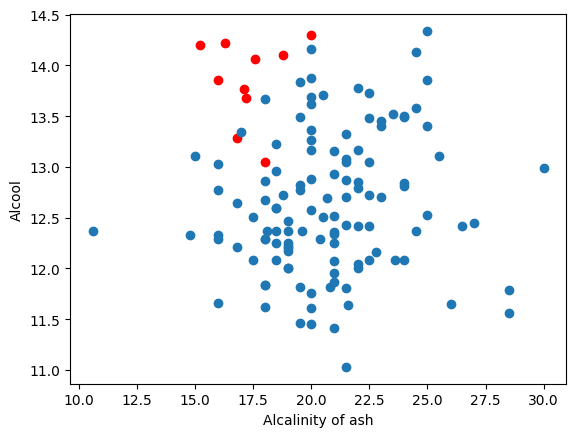

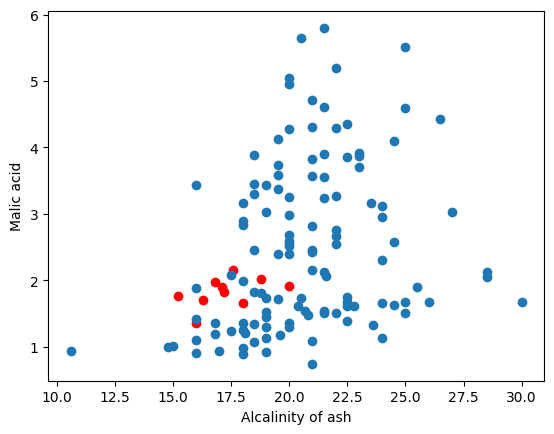

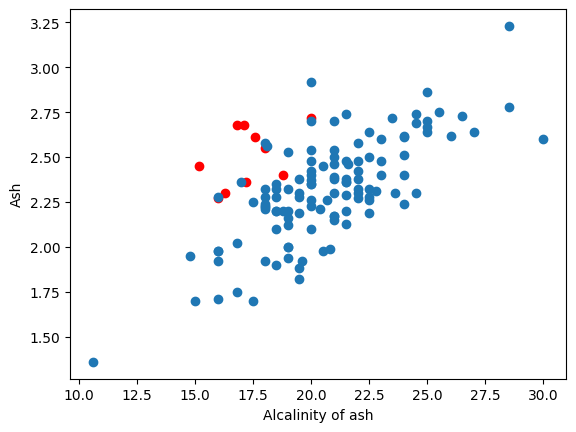

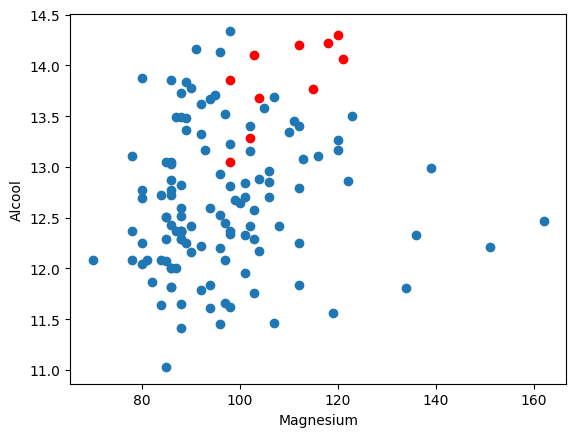

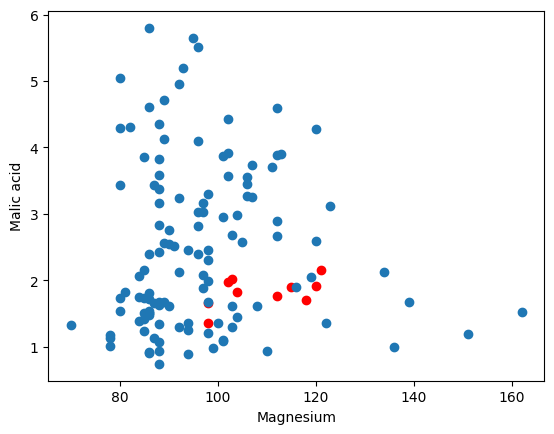

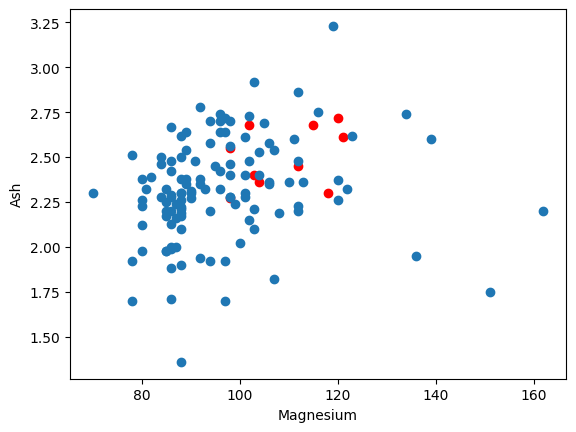

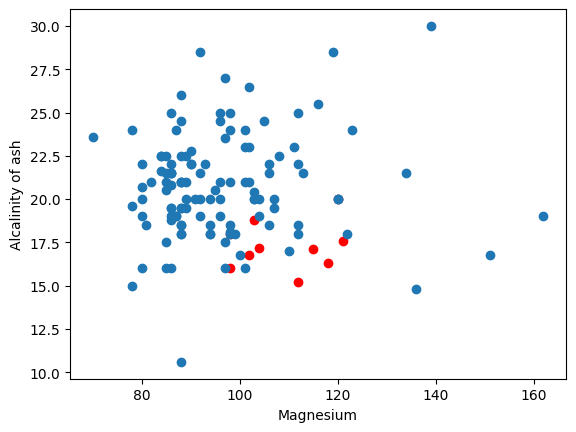

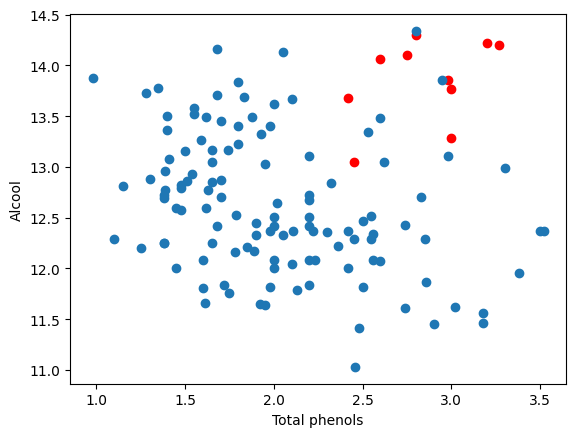

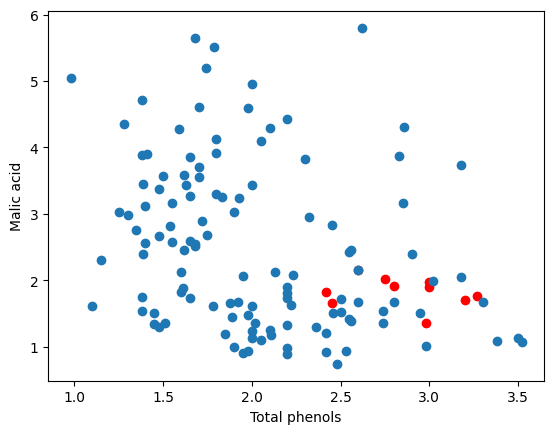

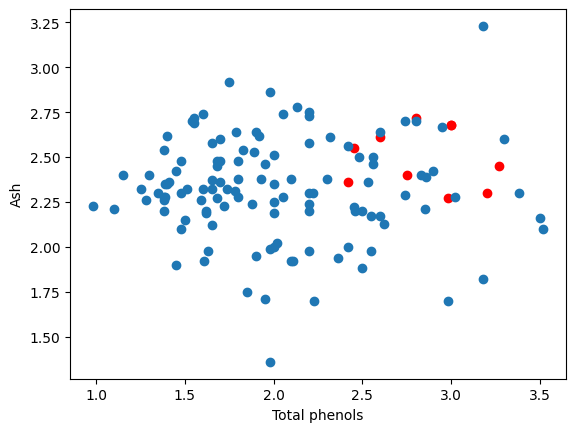

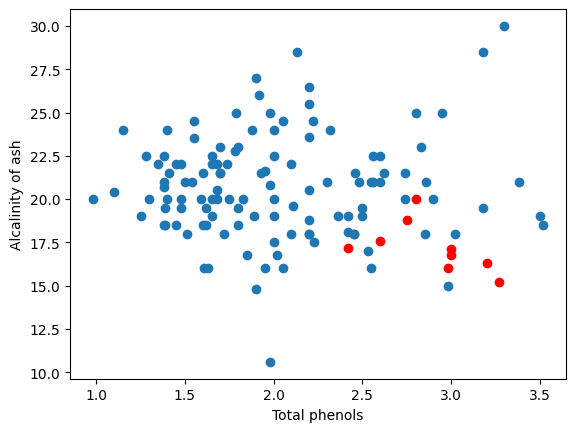

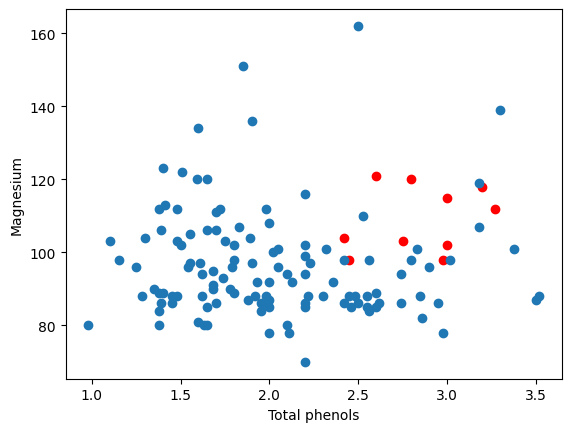

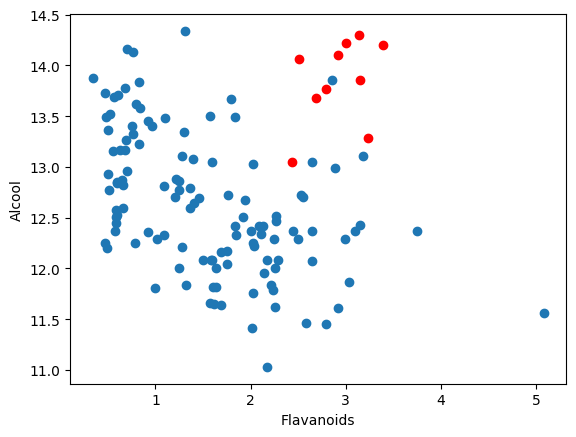

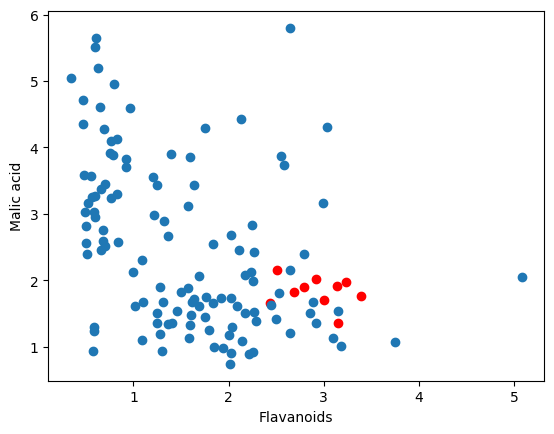

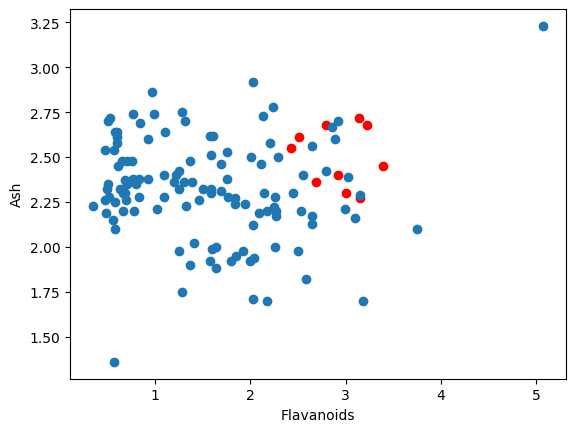

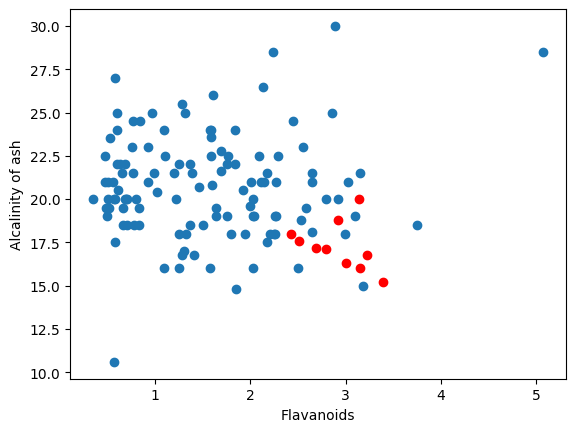

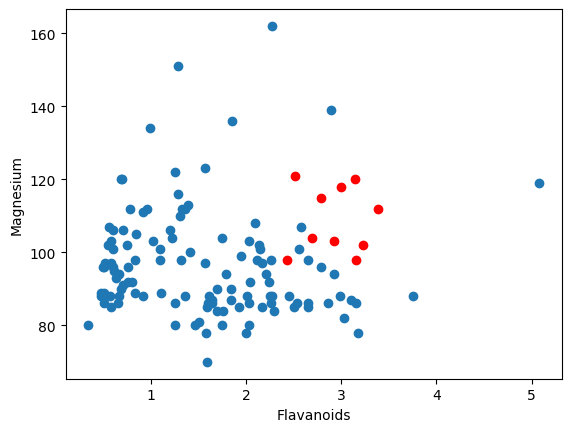

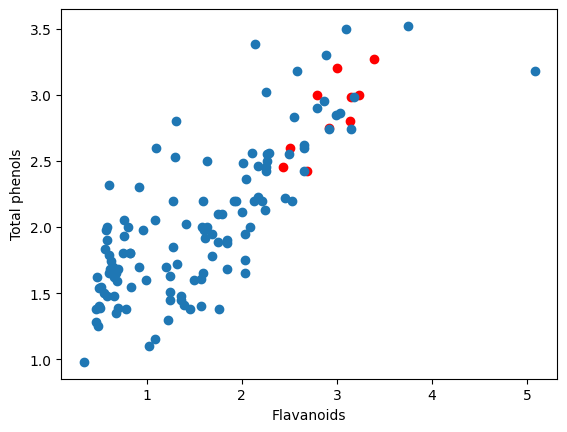

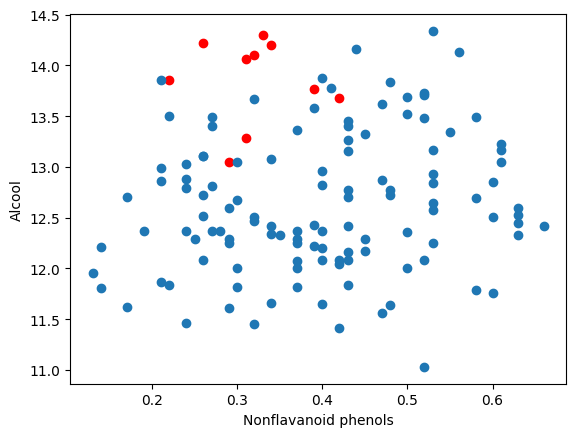

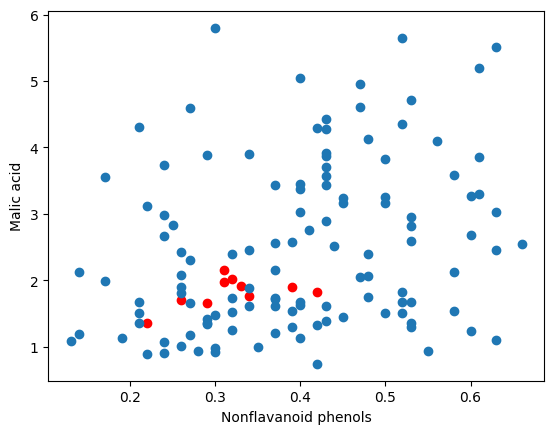

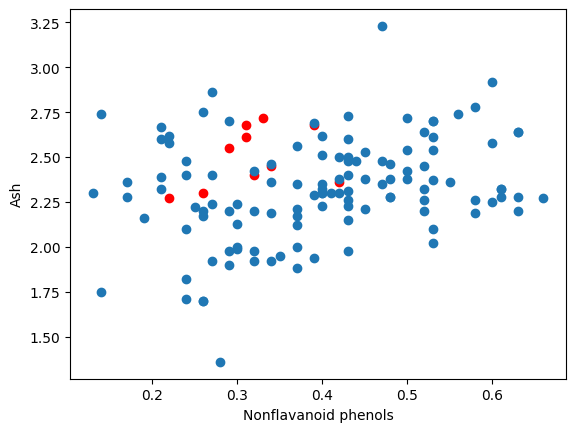

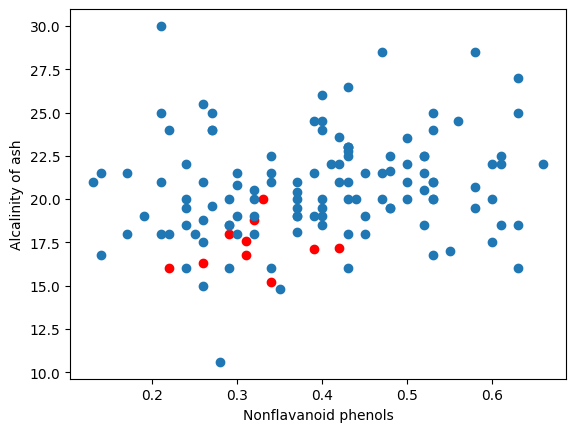

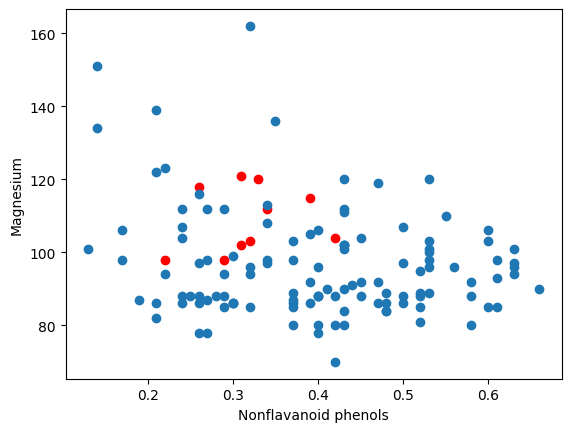

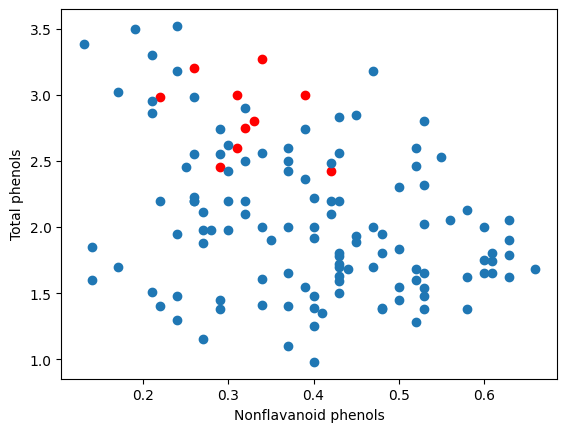

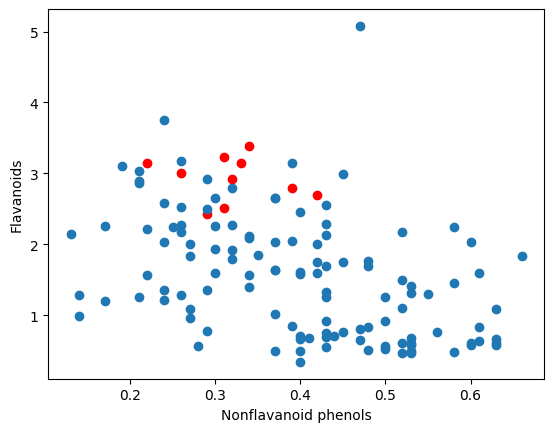

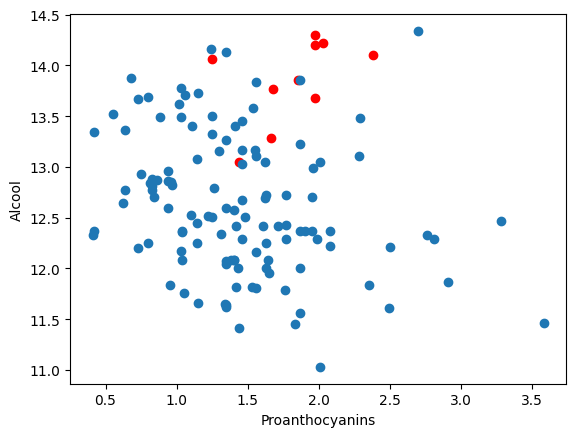

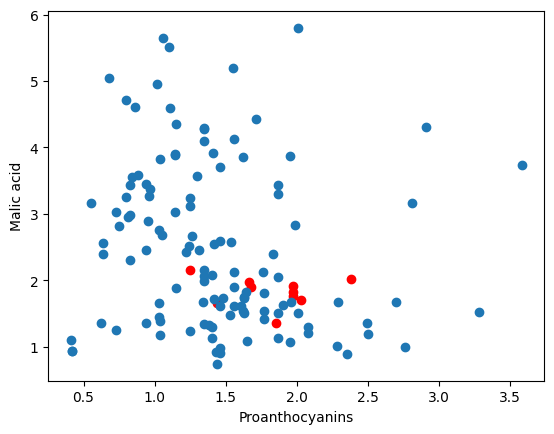

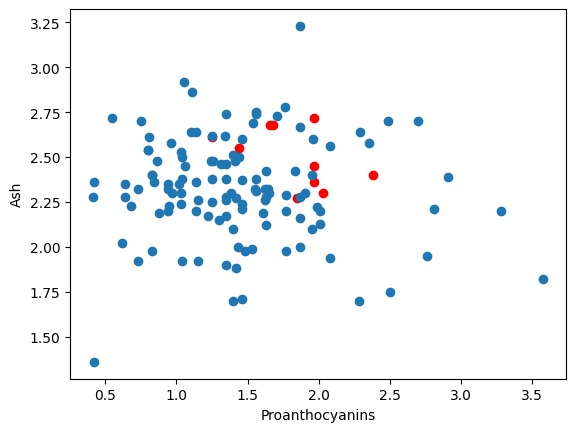

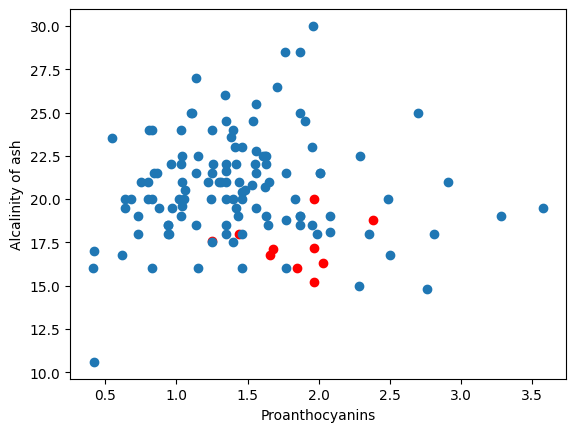

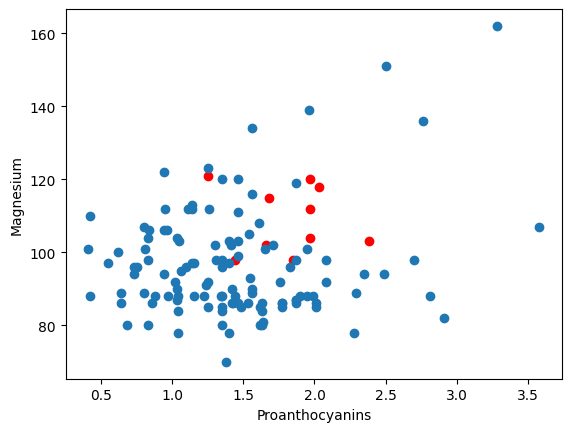

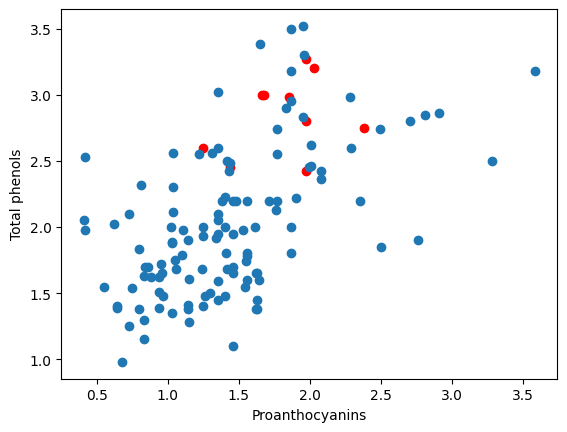

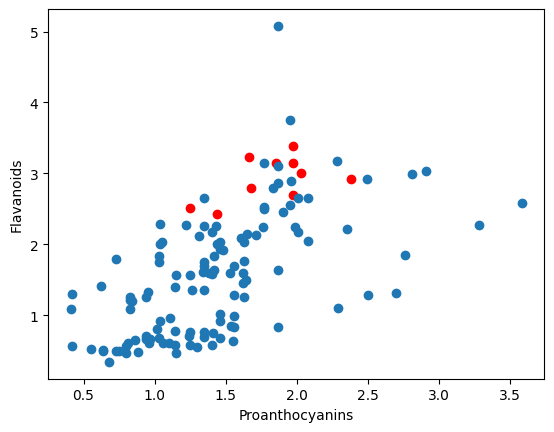

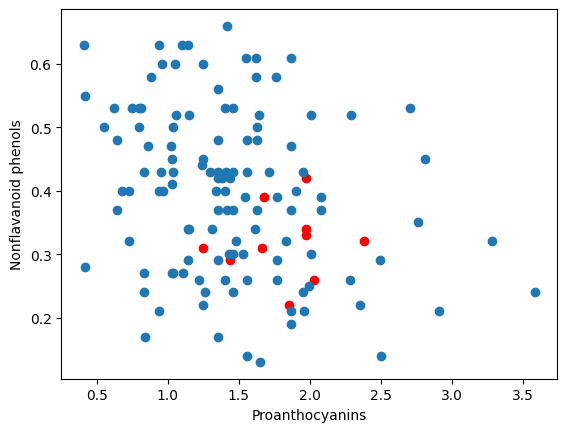

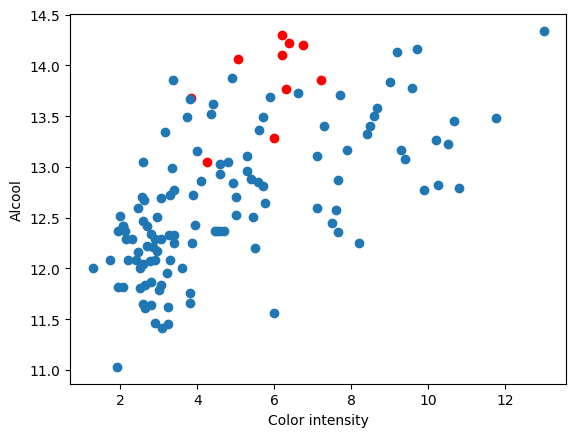

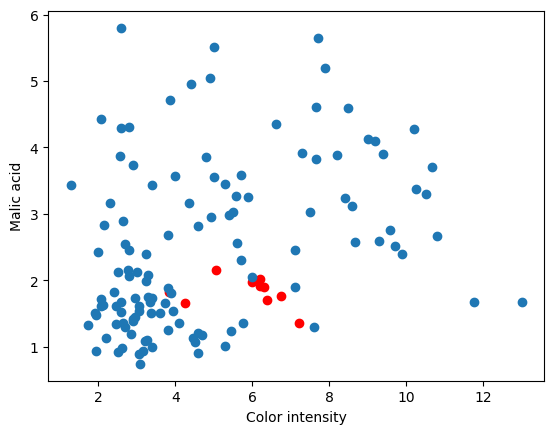

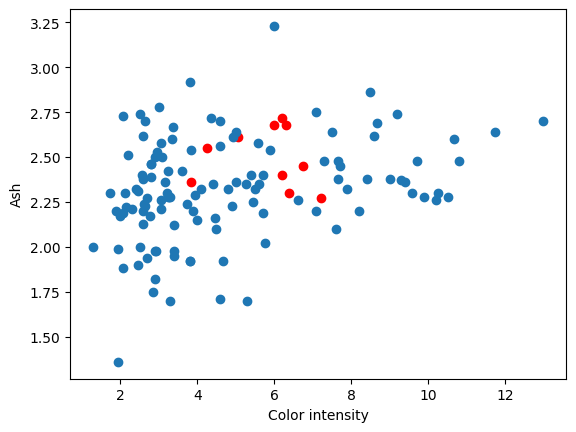

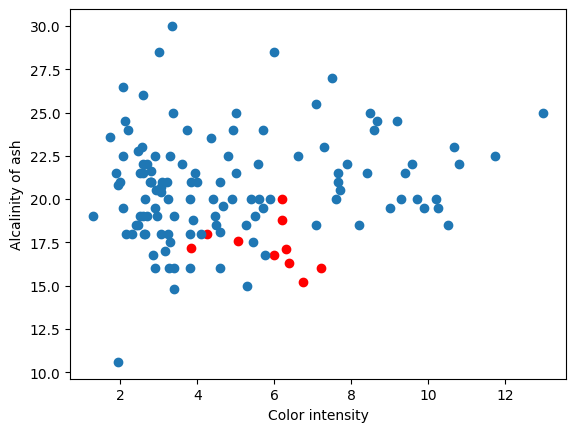

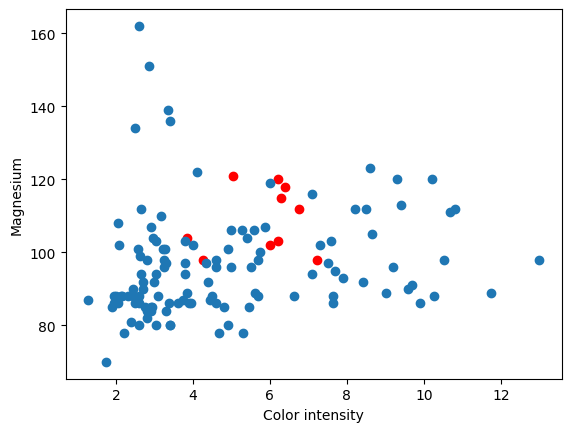

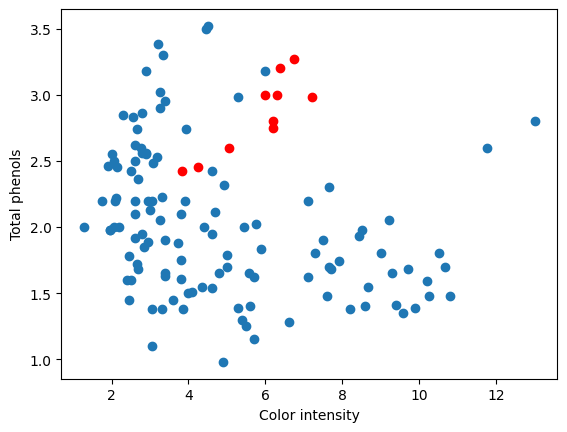

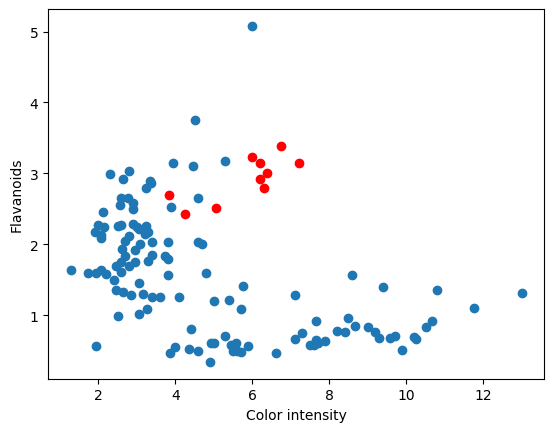

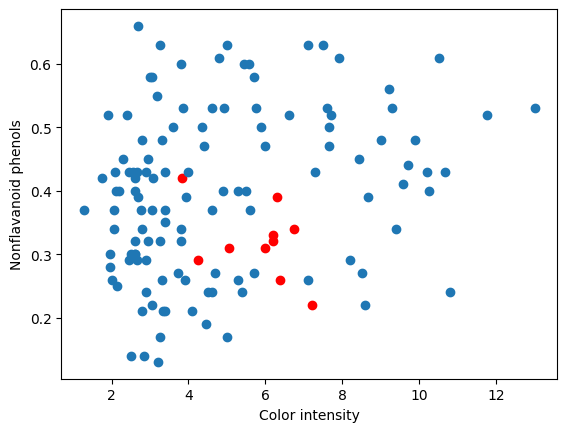

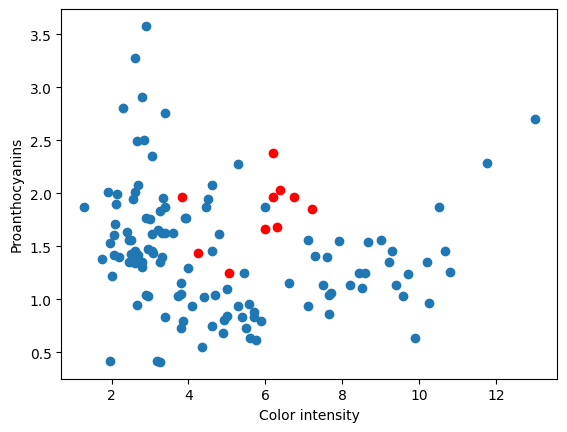

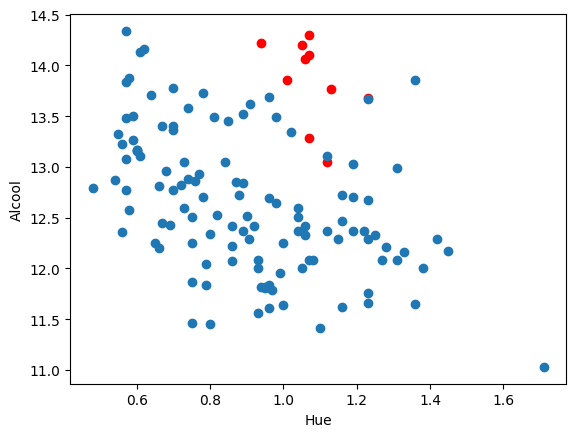

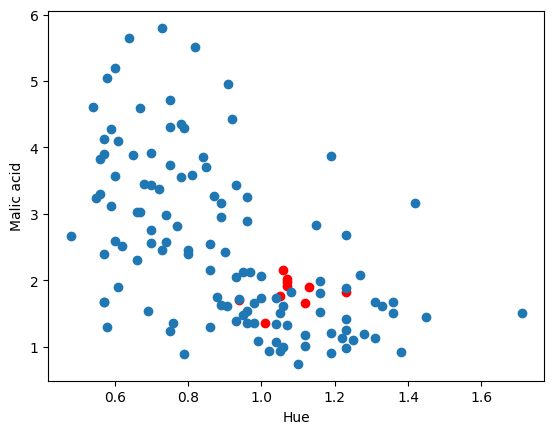

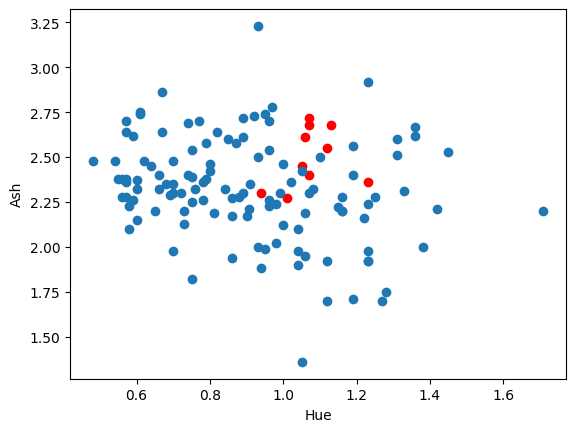

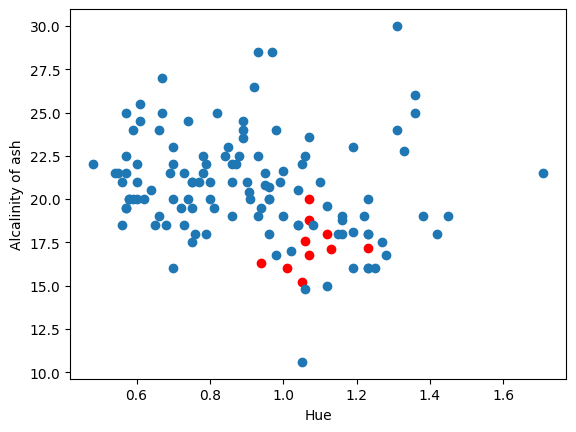

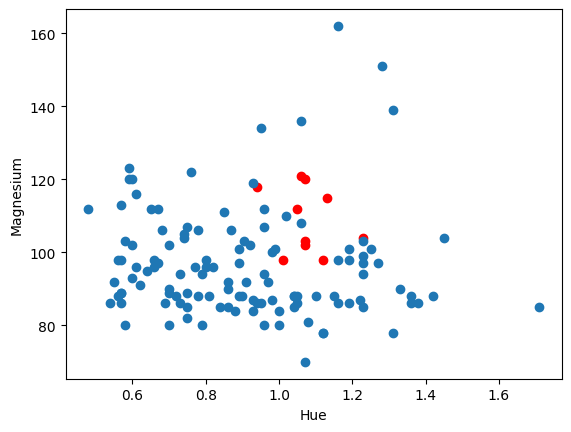

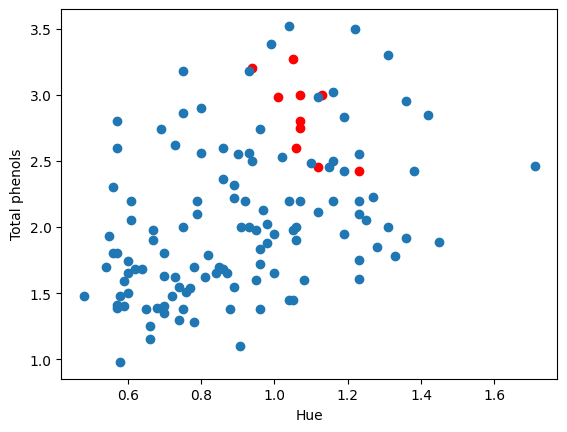

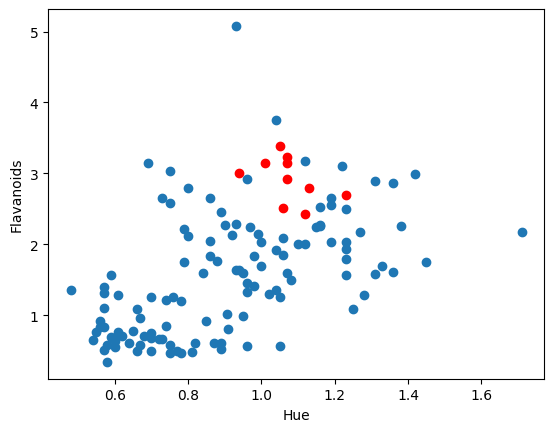

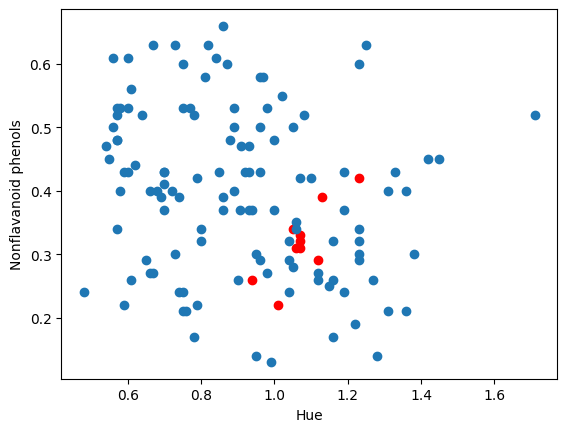

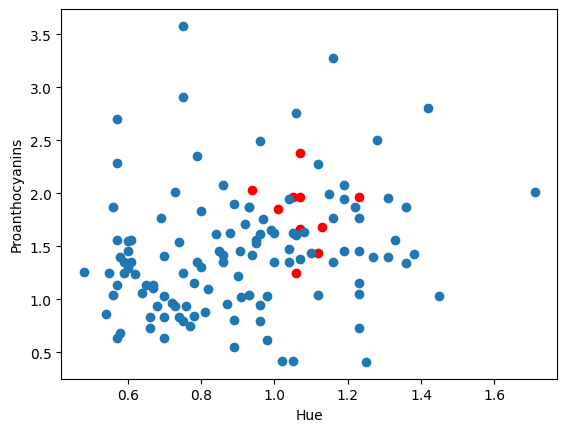

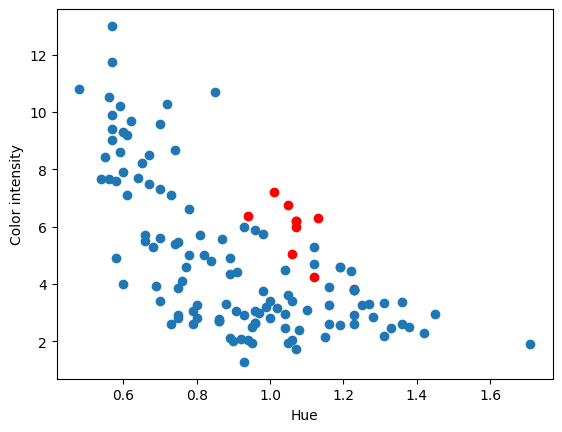

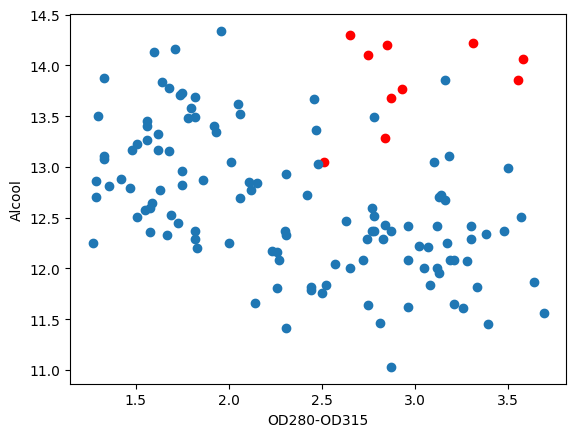

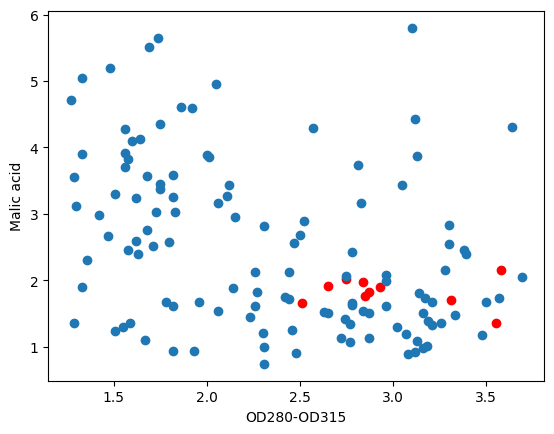

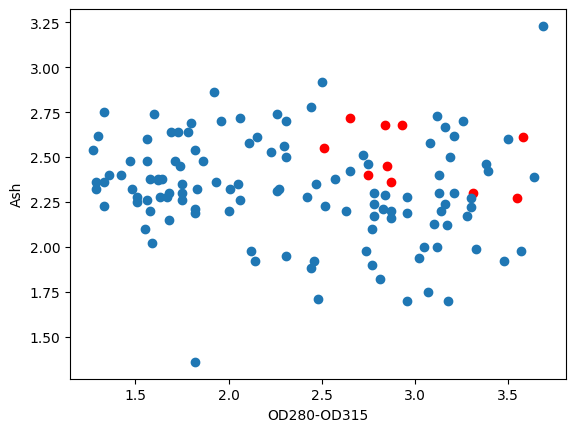

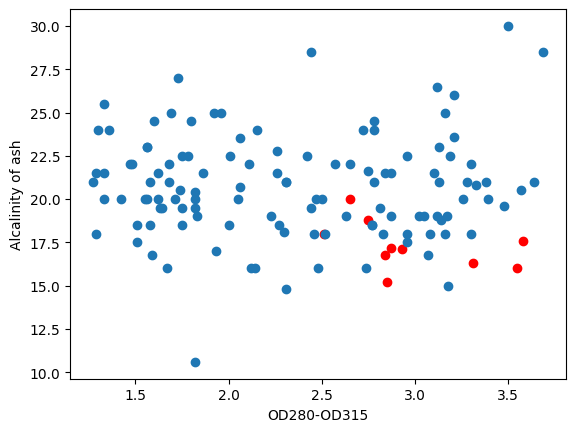

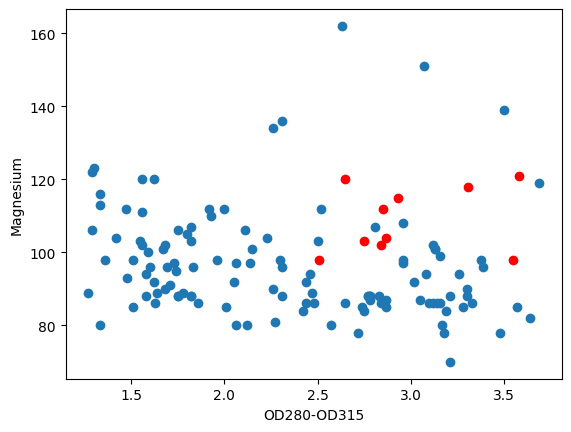

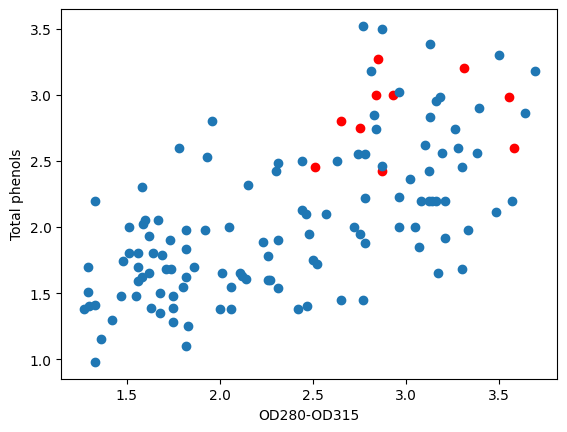

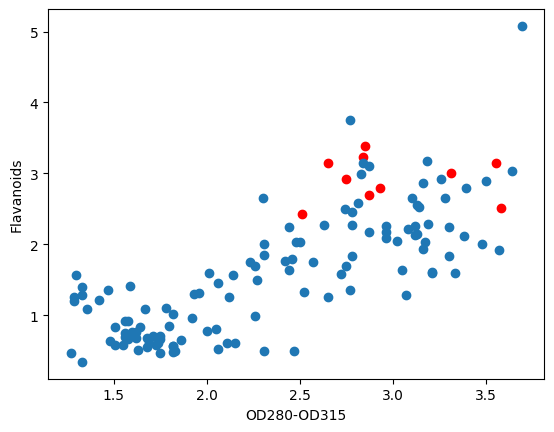

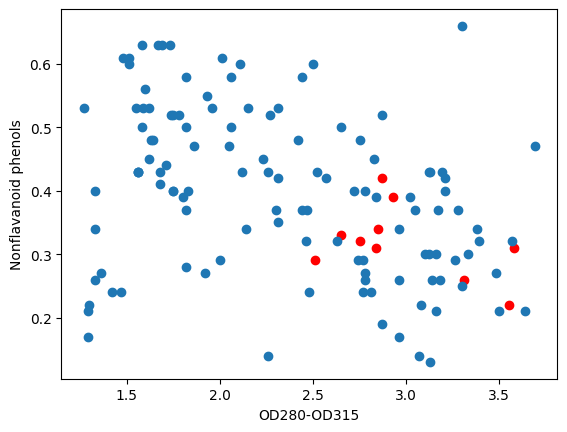

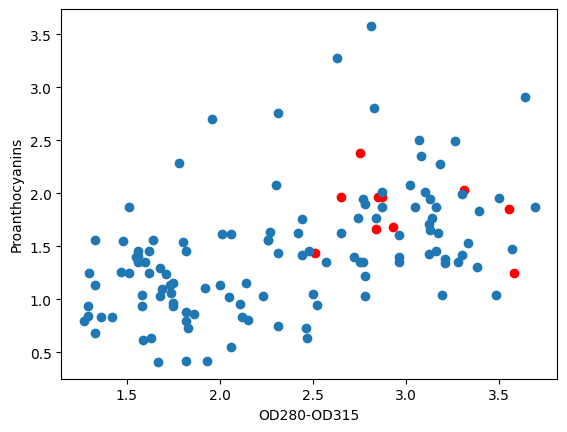

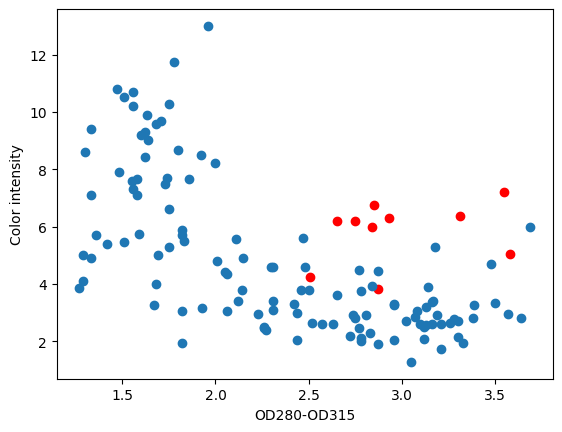

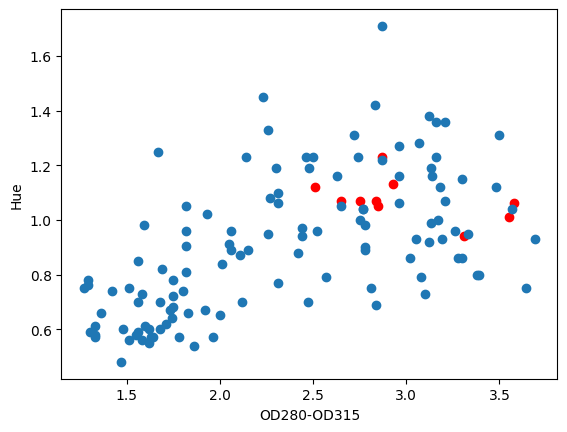

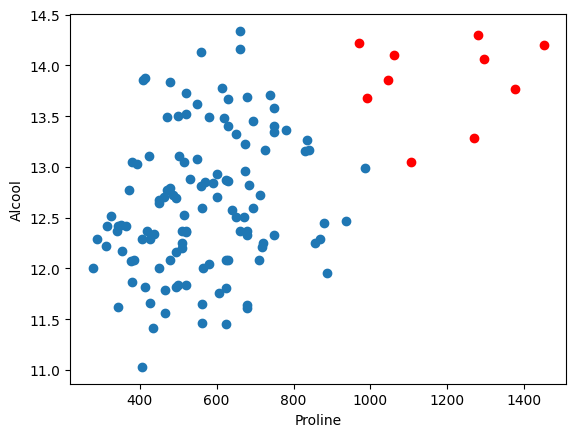

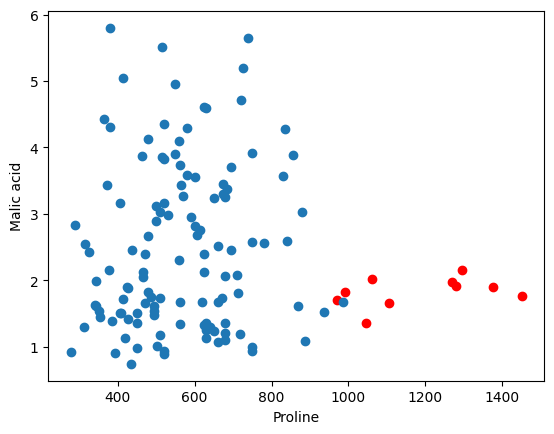

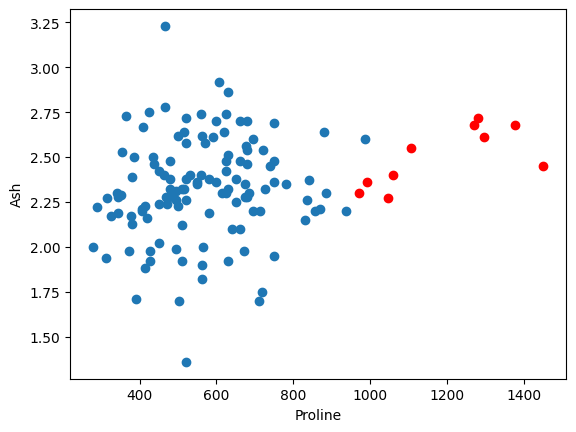

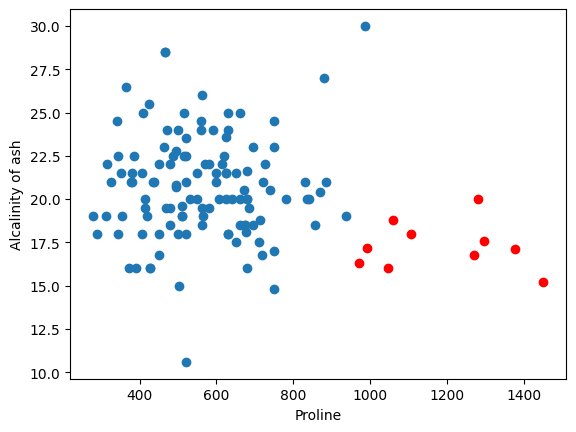

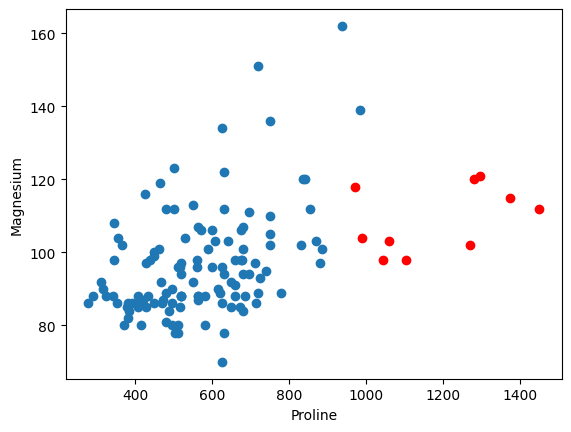

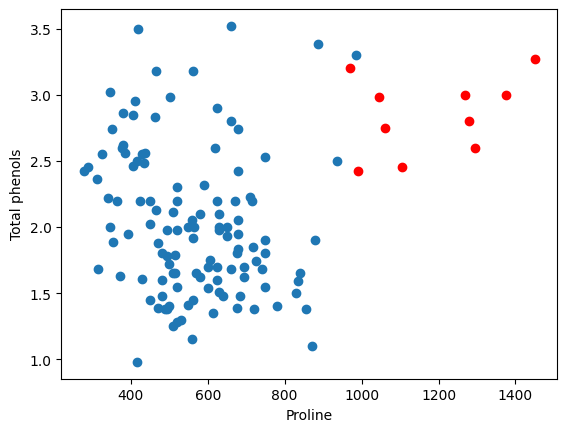

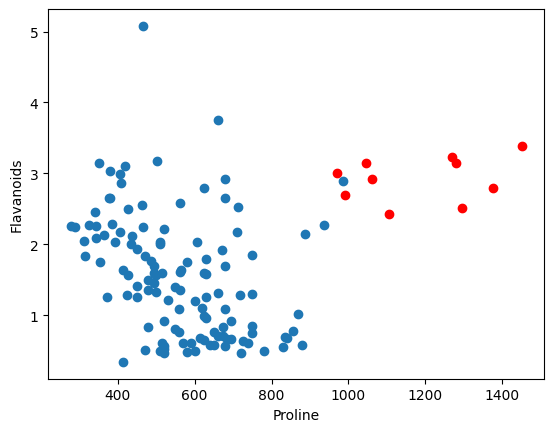

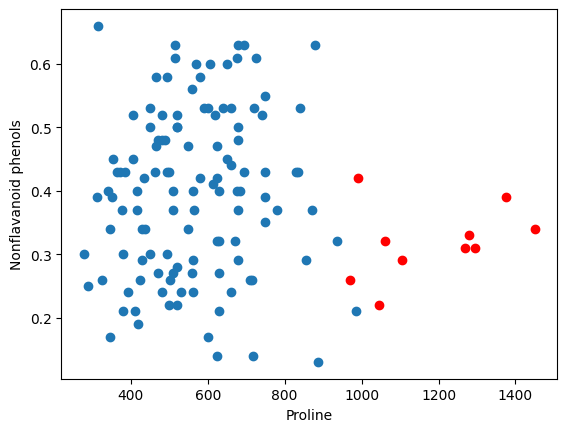

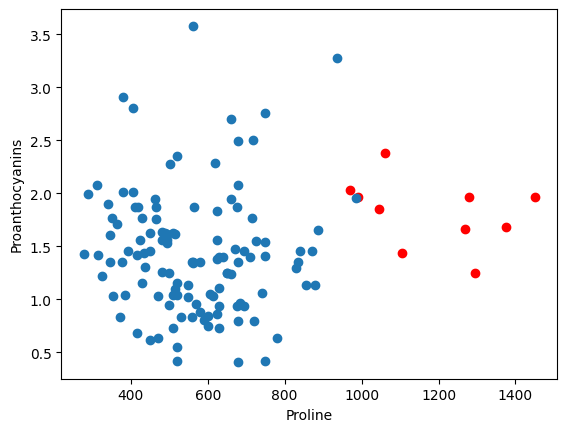

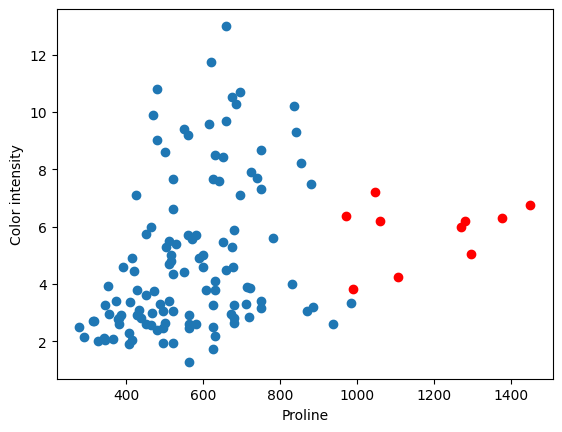

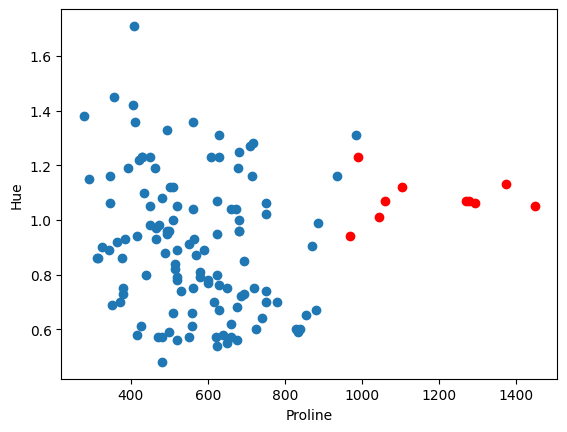

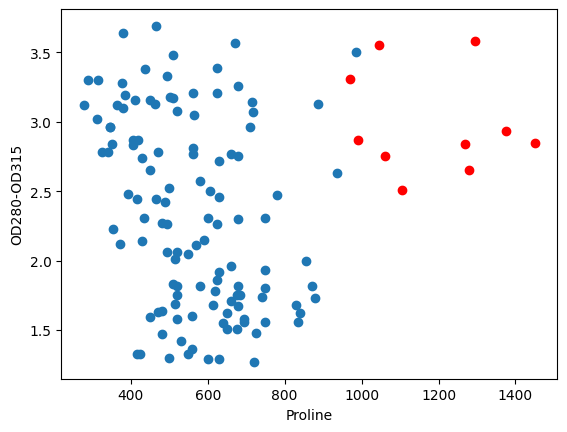

In [109]:
# Scatter plot para todos os pares possíveis de atributos
pos_out = y[y == -1].index
pos_in = y[y == 1].index

for i in range(x.shape[1]):
    for j in range(i):
        if (i != j):
            plt.figure()
            plt.scatter(x.iloc[pos_out, i], x.iloc[pos_out, j], color='red')
            plt.scatter(x.iloc[pos_in, i], x.iloc[pos_in, j])
            plt.xlabel(x.columns[i])
            plt.ylabel(x.columns[j])


In [110]:
# Dividir o conjunto de dados em 70% para treino e 30% para teste

x_outlier = x.drop(index = pos_in)

y_outlier = y.drop(index = pos_in)

x = x.drop(index = pos_out)

y = y.drop(index = pos_out)

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.30, random_state=123, shuffle=True)

y_teste = pd.concat([y_teste, y_outlier])

x_teste = pd.concat([x_teste, x_outlier])


In [111]:
#abordagem "tradicional": kNN
kNN = KNeighborsClassifier(n_neighbors = 1)
kNN.fit(x_treino, y_treino)
res = kNN.predict(x_teste)

In [112]:
# Matriz de confusão conforme a função 'confusion_matrix'
#∣∣∣VNFNFPVP∣∣∣

#Onde:

#VP: verdadeiros positivos
#FN: falsos negativos
#VN: verdadeiros negativos
#FP: falsos positivos

mat = confusion_matrix(y_teste, res)
mat


array([[ 0, 10],
       [ 0, 36]])

In [113]:
vn, fp, fn, vp = mat.ravel()

In [114]:
# Acurácia (Ac)Ac=VP+VNVP+FN+VN+FP
accuracy_score(y_teste, res)

0.782608695652174

In [115]:
(vp + vn) / (vp + vn + fn + fp)

0.782608695652174

In [116]:
#Valor preditivo positivo (VPP/precisão) VPP=VPVP+FP
vp / (vp + fp)

0.782608695652174

In [117]:
#Sensitividade (Sen) Sen=VPVP+FN
vp / (vp + fn)

1.0

In [118]:
# Valor preditivo negativo (VPN) VPN=VNVN+FN
vn

0

In [119]:
fn

0

In [120]:
#Specificidade (Esp) Esp=VNVN+FP
vn / (vn + fp)

0.0

In [121]:
# Detecção de novidades utilizando local outlier factor, que é baseado em kNN
lof = LocalOutlierFactor(novelty=True)
lof.fit(x_treino, y_treino)

LocalOutlierFactor(novelty=True)

In [122]:
resLof = lof.predict(x_teste)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [123]:
mat = confusion_matrix(y_teste, resLof)
mat

array([[10,  0],
       [ 2, 34]])

In [124]:
vn, fp, fn, vp = mat.ravel()
accuracy_score(y_teste, resLof)

0.9565217391304348

In [125]:
VPP = vp / (vp + fp)
VPP

1.0

In [126]:
Sen = vp / (vp + fn)
Sen

0.9444444444444444

In [127]:
VPN = vn / (vn + fn)
VPN

0.8333333333333334

In [128]:
Spe = vn / (vn + fp)
Spe

1.0

In [129]:
# Detecção de novidades utilizando one-class SVM
#O parâmetro 'nu' tem a finalidade de ajustar o limite entre a generalização e o overfitting
oSVM = OneClassSVM(nu=0.125)
oSVM.fit(x_treino, y_treino)

OneClassSVM(nu=0.125)

In [130]:
resOSVM = oSVM.predict(x_teste)
mat = confusion_matrix(y_teste, resOSVM)
mat

array([[10,  0],
       [ 1, 35]])

In [131]:
vn, fp, fn, vp = mat.ravel()
accuracy_score(y_teste, resOSVM)

0.9782608695652174

In [132]:
VPP = vp / (vp + fp)
VPP

1.0

In [133]:
Sen = vp / (vp + fn)
Sen

0.9722222222222222

In [134]:
Spe = vn / (vn + fp)
Spe

1.0

<Axes: >

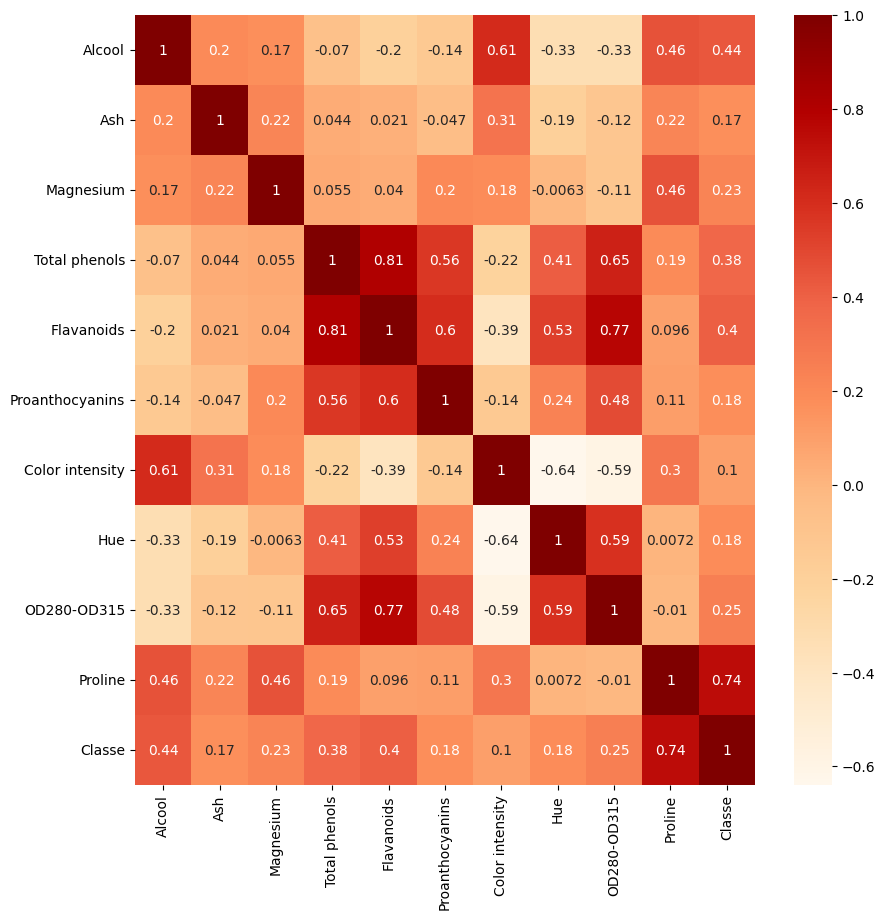

In [135]:
#Após a execução, remova os atributos que possuem correlação negativa com o atributo 'Classe'
#Os atributos que tem correlação negativa com o atributo "Classe" são: "Nonflavanoid phenols", "Alcalinity of ash" e "Malic acid".
# Remover colunas com correlação negativa em relação à 'Classe'
correlation = bd.corr()['Classe'].drop('Classe')
columns_to_remove = correlation[correlation < 0].index
bd = bd.drop(columns_to_remove, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(bd.corr(), annot=True, cmap='OrRd')

In [136]:
#Na divisão do conjunto de dados, conforme feita na linha 24, faça com que o conjunto de treinamento também tenha outliers.
y_treino = pd.concat([y_treino, y_outlier])
x_treino = pd.concat([x_treino, x_outlier])

In [137]:
#Execute novamente o código e verifique se houve melhora de desempenho nos modelos.
#KNN
kNN = KNeighborsClassifier(n_neighbors = 1)
kNN.fit(x_treino, y_treino)

KNeighborsClassifier(n_neighbors=1)

In [138]:
res = kNN.predict(x_teste)

In [139]:
mat = confusion_matrix(y_teste, res)
mat

array([[10,  0],
       [ 0, 36]])

In [140]:
vn, fp, fn, vp = mat.ravel()

In [141]:
# Acuracia
accuracy_score(y_teste, res)

1.0

In [142]:
#VPP
vp / (vp + fp)

1.0

In [143]:
# SEN
vp / (vp + fn)

1.0

In [144]:
# ESP
vn / (vn + fp)

1.0

Observou-se, com a insercao de outliers, que houve significativa melhora na predicao KNN

In [145]:
# Local outlier factor
lof = LocalOutlierFactor(novelty=True)
lof.fit(x_treino, y_treino)

LocalOutlierFactor(novelty=True)

In [146]:
resLof = lof.predict(x_teste)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [147]:
mat = confusion_matrix(y_teste, resLof)
mat

array([[10,  0],
       [ 2, 34]])

In [148]:
vn, fp, fn, vp = mat.ravel()
accuracy_score(y_teste, resLof)

0.9565217391304348

In [149]:
VPP = vp / (vp + fp)
VPP

1.0

In [150]:
Sen = vp / (vp + fn)
Sen

0.9444444444444444

In [151]:
VPN = vn / (vn + fn)
VPN

0.8333333333333334

In [152]:
Spe = vn / (vn + fp)
Spe

1.0

 No Local Outlier Factor, nao houveram alteracoes com a inclusao de outliers


In [153]:
#One class svm
oSVM = OneClassSVM(nu=0.125)
oSVM.fit(x_treino, y_treino)

OneClassSVM(nu=0.125)

In [154]:
resOSVM = oSVM.predict(x_teste)

In [155]:
mat = confusion_matrix(y_teste, resOSVM)
mat

array([[ 5,  5],
       [ 0, 36]])

In [156]:
vn, fp, fn, vp = mat.ravel()
accuracy_score(y_teste, resOSVM)

0.8913043478260869

In [157]:
VPP = vp / (vp + fp)
VPP

0.8780487804878049

In [158]:
Sen = vp / (vp + fn)
Sen

1.0

In [159]:
VPN = vn / (vn + fn)
VPN

1.0

In [160]:
Spe = vn / (vn + fp)
Spe

0.5

Unsando outro classificador


In [161]:
# RF
from sklearn.ensemble import RandomForestClassifier
rf_modelo = RandomForestClassifier()
rf_modelo.fit(x_treino, y_treino)


RandomForestClassifier()

In [162]:
rf_y_pred = rf_modelo.predict(x_teste)

In [163]:
rf_acuracia = accuracy_score(y_teste, rf_y_pred)
print("Random Forest Acurácia:", rf_acuracia)

Random Forest Acurácia: 1.0


In [164]:
# Matriz de confusão conforme a função 'confusion_matriX
mat = confusion_matrix(y_teste, rf_y_pred)
mat


array([[10,  0],
       [ 0, 36]])

In [167]:
vn, fp, fn, vp = mat.ravel()
accuracy_score(y_teste, resLof)


0.9565217391304348

In [169]:
accuracy_score(y_teste, rf_y_pred)
(vp + vn) / (vp + vn + fn + fp)

1.0

In [170]:
VPP = vp / (vp + fp)
VPP

1.0

In [171]:
Sen = vp / (vp + fn)
Sen

1.0

In [172]:
VPN = vn / (vn + fn)
VPN

1.0

In [173]:
Spe = vn / (vn + fp)
Spe

1.0

o modelo RF trouxe excelente resultados no processo de classificacao